geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomeno

Ref: https://www.kaggle.com/ahmetekti/named-entity-recognition-using-deep-learnin-8348ac

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
from sklearn import metrics
from keras import backend as K
plt.style.use('seaborn')

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [4]:
# getting the data
file = "input-datasets/EDLC_ner_dataset_V3.csv"
data = pd.read_csv(file, encoding = "utf-8")

# drop the docId column because we dont need it
data = data.drop('docId', 1)


data.head()

# Fill na
# data = data.fillna(method = 'ffill')


words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

print(f"Total number of unique words in dataset: {num_words}")

tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")



Total number of unique words in dataset: 1550
List of tags: B-mat, I-mat, B-electrolyte, I-electrolyte, B-morph, I-proc, B-val, I-morph, O, B-proc, I-val
Total Number of tags 11


[('the', 'O'), ('nanowire', 'B-morph'), ('shell', 'O'), ('is', 'O'), ('composed', 'O'), ('of', 'O'), ('2D', 'B-morph'), ('WS2', 'B-mat'), ('with', 'O'), ('subnanometer', 'O'), ('physical', 'O'), ('gaps', 'O'), ('van', 'O'), ('der', 'O'), ('Waals', 'O'), ('gaps', 'O'), ('in', 'O'), ('between', 'O'), ('individual', 'O'), ('2D', 'B-morph'), ('layers', 'O'), ('for', 'O'), ('facile', 'O'), ('ion', 'O'), ('absorption', 'O'), ('from', 'O'), ('electrolytes', 'O')]


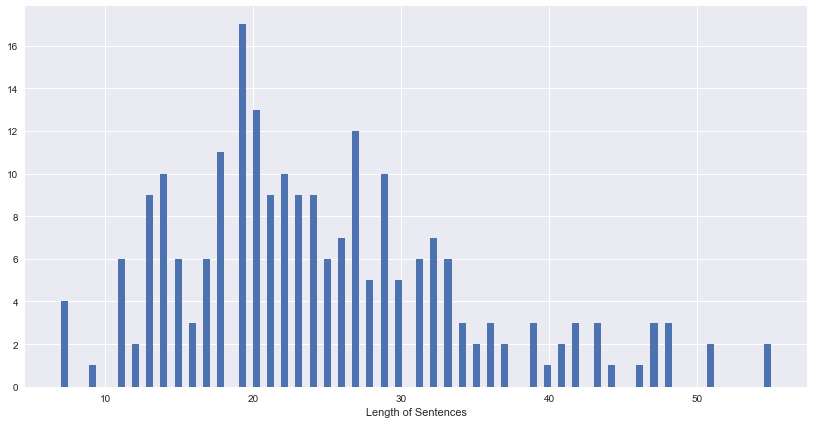

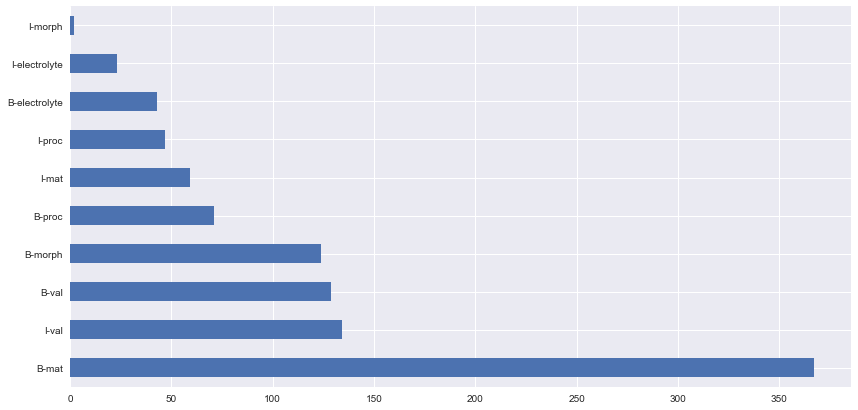

In [5]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("SentenceID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
        
getter = Get_sentence(data)
sentence = getter.sentences
print(sentence[10])

plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 100)
plt.xlabel("Length of Sentences")
plt.show()

plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();






In [6]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

print(tag_idx)

max_len = 60
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words - 1)

y = [[tag_idx[w[1]] for w in s] for s in sentence]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag_idx['O'])
y = [to_categorical(i, num_classes = num_tags) for i in  y]

x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.1, random_state = 1)

{'B-mat': 0, 'I-mat': 1, 'B-electrolyte': 2, 'I-electrolyte': 3, 'B-morph': 4, 'I-proc': 5, 'B-val': 6, 'I-morph': 7, 'O': 8, 'B-proc': 9, 'I-val': 10}


In [7]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0)(model)
model = Bidirectional(LSTM(units = 1000,return_sequences = True, recurrent_dropout = 0.01))(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)


model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy',precision_m, recall_m, f1_m])

# model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])   ## Main compile phase
model.summary()  ## print model summary

plot_model(model, show_shapes = True)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 60)            93000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 60)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 2000)          8488000   
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 11)            22011     
Total params: 8,603,011
Trainable params: 8,603,011
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [8]:
model.fit(x_train, np.array(y_train), batch_size = 16, verbose = 1, epochs = 50, validation_split = 0.2)


print("Model Evaluation \n===========================\n")
model.evaluate(x_test, np.array(y_test))

rand_sent = np.random.randint(0, x_test.shape[0]) # get a random sentence
p = model.predict(np.array([x_test[rand_sent]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[rand_sent] # get actual tags for random sentense

print("{:20}{:20}\t{}\n".format("Word", "True", "Pred"))
print("-" * 55)

for (w, t, pred) in zip(x_test[rand_sent], y_true, p[0]):
    print("{:20}{:20}\t{}".format(words[w - 1], tags[t], tags[pred]))
    

# y_pred = model.predict(x_test, batch_size=64, verbose=1)
# y_pred_bool = np.argmax(y_pred, axis=1)

# print(metrics.classification_report(y_test,y_pred))
    


Epoch 1/50
10/10 [==============================] - 4s 387ms/step - loss: 1.1487 - accuracy: 0.8074 - precision_m: 0.6516 - recall_m: 0.5868 - f1_m: 0.6150 - val_loss: 0.4066 - val_accuracy: 0.9304 - val_precision_m: 0.9404 - val_recall_m: 0.8226 - val_f1_m: 0.8775
Epoch 2/50
10/10 [==============================] - 3s 338ms/step - loss: 0.4141 - accuracy: 0.9226 - precision_m: 0.9235 - recall_m: 0.9109 - f1_m: 0.9168 - val_loss: 0.3390 - val_accuracy: 0.9304 - val_precision_m: 0.9260 - val_recall_m: 0.9253 - val_f1_m: 0.9257
Epoch 3/50
10/10 [==============================] - 3s 335ms/step - loss: 0.3652 - accuracy: 0.9226 - precision_m: 0.9225 - recall_m: 0.9220 - f1_m: 0.9223 - val_loss: 0.3295 - val_accuracy: 0.9304 - val_precision_m: 0.9260 - val_recall_m: 0.9260 - val_f1_m: 0.9260
Epoch 4/50
10/10 [==============================] - 3s 338ms/step - loss: 0.3539 - accuracy: 0.9226 - precision_m: 0.9226 - recall_m: 0.9219 - f1_m: 0.9222 - val_loss: 0.3305 - val_accuracy: 0.9304 - va

Epoch 32/50
10/10 [==============================] - 3s 333ms/step - loss: 0.0425 - accuracy: 0.9879 - precision_m: 0.9962 - recall_m: 0.9816 - f1_m: 0.9888 - val_loss: 0.2567 - val_accuracy: 0.9592 - val_precision_m: 0.9667 - val_recall_m: 0.9503 - val_f1_m: 0.9584
Epoch 33/50
10/10 [==============================] - 3s 332ms/step - loss: 0.0388 - accuracy: 0.9894 - precision_m: 0.9965 - recall_m: 0.9844 - f1_m: 0.9904 - val_loss: 0.2494 - val_accuracy: 0.9596 - val_precision_m: 0.9654 - val_recall_m: 0.9521 - val_f1_m: 0.9587
Epoch 34/50
10/10 [==============================] - 3s 341ms/step - loss: 0.0339 - accuracy: 0.9910 - precision_m: 0.9970 - recall_m: 0.9850 - f1_m: 0.9910 - val_loss: 0.2576 - val_accuracy: 0.9608 - val_precision_m: 0.9651 - val_recall_m: 0.9531 - val_f1_m: 0.9591
Epoch 35/50
10/10 [==============================] - 4s 364ms/step - loss: 0.0310 - accuracy: 0.9916 - precision_m: 0.9972 - recall_m: 0.9870 - f1_m: 0.9920 - val_loss: 0.2658 - val_accuracy: 0.9600 

In [9]:
def create_test_input_from_text(text):
    word_list = text.split(" ")
    x_new = []
    for word in word_list:
        x_new.append(word_idx[word])
        
    p = model.predict(np.array([x_new]))
    p = np.argmax(p, axis = -1)
    print("{:20}\t{}\n".format("Word", "Prediction"))
    print("-" * 35)

    for (w, pred) in zip(range(len(x_new)), p[0]):
        print("{:20}\t{}".format(word_list[w], tags[pred]))

test_inputs = "Hierarchical Porous Nitrogen-Doped Carbon Nanosheets Derived from Silk for Ultrahigh-Capacity Battery Anodes and Supercapacitors"
create_test_input_from_text(test_inputs)

test_inputs = "Li metal foil as the counter electrode and 1 M LiPF6 solution with ethylene carbonate-dimethyl carbonate as the electrolyte"
create_test_input_from_text(test_inputs)

Word                	Prediction

-----------------------------------
Hierarchical        	B-mat
Porous              	I-mat
Nitrogen-Doped      	I-mat
Carbon              	I-mat
Nanosheets          	O
Derived             	O
from                	O
Silk                	O
for                 	O
Ultrahigh-Capacity  	O
Battery             	O
Anodes              	B-morph
and                 	O
Supercapacitors     	O
Word                	Prediction

-----------------------------------
Li                  	B-mat
metal               	O
foil                	O
as                  	O
the                 	O
counter             	O
electrode           	O
and                 	O
1                   	B-val
M                   	I-val
LiPF6               	B-electrolyte
solution            	O
with                	O
ethylene            	B-val
carbonate-dimethyl  	I-val
carbonate           	I-val
as                  	I-electrolyte
the                 	B-val
electrolyte         	B-val
